In [11]:
import os
import sys

ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
SRC = os.path.join(ROOT, 'src')
sys.path.append(SRC)

import mirdata
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from collections import defaultdict
import seaborn as sns


## Load Dataset

In [12]:
# ----- Load Dataset -----
data_home = '../../../datasets/CMR'

carn = mirdata.initialize('compmusic_carnatic_rhythm', version='full_dataset_1.0', data_home=data_home, )
carn.download(['index'])
#carn.download() # run once and comment line
#carn.validate()
carn_tracks = carn.load_tracks()
carn_keys = list(carn_tracks.keys())

INFO: Downloading ['index', 'index']. Index is being stored in /Users/satyajeetprabhu/miniconda3/envs/carnatictcn/lib/python3.10/site-packages/mirdata/datasets/indexes, and the rest of files in ../../../datasets/CMR
INFO: [index] downloading compmusic_carnatic_rhythm_full_index_1.0.json
INFO: /Users/satyajeetprabhu/miniconda3/envs/carnatictcn/lib/python3.10/site-packages/mirdata/datasets/indexes/compmusic_carnatic_rhythm_full_index_1.0.json already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: [index] downloading compmusic_carnatic_rhythm_full_index_1.0.json
INFO: /Users/satyajeetprabhu/miniconda3/envs/carnatictcn/lib/python3.10/site-packages/mirdata/datasets/indexes/compmusic_carnatic_rhythm_full_index_1.0.json already exists and will not be downloaded. Rerun with force_overwrite=True to delete this file and force the download.
INFO: The files of this dataset are shared under request. Please go to: https://zenodo.o

## Read Dataset Tempo Information

In [13]:
all_ibis = []  # to store all inter-beat intervals (IBIs)
count_fast_tracks = 0 # to count tracks with fast tempos
threshold_bpm = 230  # threshold for fast tracks
track_tempo_list = [] # to store tempo metrics for each track
taala_ibis_dict = defaultdict(list) # to store IBIs for each taala
taala_cycle_lengths = defaultdict(list) # to store cycle lengths for each taala

for k in carn_keys:
    beat_times = carn_tracks[k].beats.times
    beat_pos = carn_tracks[k].beats.positions.astype(int)
    downbeat_times = beat_times[beat_pos == 1]
    
    if beat_times is None or len(beat_times) < 2:
        continue  # skip if not enough beat times

    track_taala = carn_tracks[k].taala

    ibis = np.diff(beat_times)
    ibis = ibis[ibis > 0]  # exclude invalid intervals

    if len(ibis) == 0:
        continue
    
    all_ibis.extend(ibis)
    taala_ibis_dict[track_taala].extend(ibis)
    
    bpm_track = 60.0 / ibis
        
    if np.any(bpm_track > threshold_bpm):
        count_fast_tracks += 1
    

    cycle_length = np.diff(downbeat_times)
    cycle_length = cycle_length[cycle_length > 0]  # exclude invalid intervals
    taala_cycle_lengths[track_taala].extend(cycle_length)
    
    track_tempo_list.append({
        'track_id': k,
        'taala': track_taala,
        'median_bpm': np.median(bpm_track),
        'min_bpm': bpm_track.min(),
        'max_bpm': bpm_track.max(),
        'min_cycle_length': cycle_length.min(),
        'max_cycle_length': cycle_length.max(),
        'median_cycle_length': np.median(cycle_length)
    })

## Dataset Tempo Analysis

In [14]:
# Convert to arrays
all_ibis = np.array(all_ibis)
all_tempos = 60.0 / all_ibis
track_medians = np.array([t['median_bpm'] for t in track_tempo_list])

# ---- Global tempo stats (across all IBIs) ----
print(f"Global Tempo Range (across all beat intervals): {all_tempos.min():.2f} - {all_tempos.max():.2f} BPM")

# ---- Per-track median tempo stats ----
print(f"Per-Track Median Tempo Range: {track_medians.min():.2f} - {track_medians.max():.2f} BPM")
print(f"Mean Per-Track Tempo: {track_medians.mean():.2f}")
print(f"Median Per-Track Tempo: {np.median(track_medians):.2f}")
print(f"Number of tracks with tempo > {threshold_bpm} BPM: {count_fast_tracks}")

# ---- % of intervals above threshold BPM ----
percent_above_tempo = np.sum(all_tempos > threshold_bpm) / len(all_tempos) * 100
print(f"Percentage of intervals above {threshold_bpm} BPM: {percent_above_tempo:.2f}%")

Global Tempo Range (across all beat intervals): 57.10 - 364.09 BPM
Per-Track Median Tempo Range: 71.28 - 285.44 BPM
Mean Per-Track Tempo: 120.74
Median Per-Track Tempo: 101.15
Number of tracks with tempo > 230 BPM: 10
Percentage of intervals above 230 BPM: 1.01%


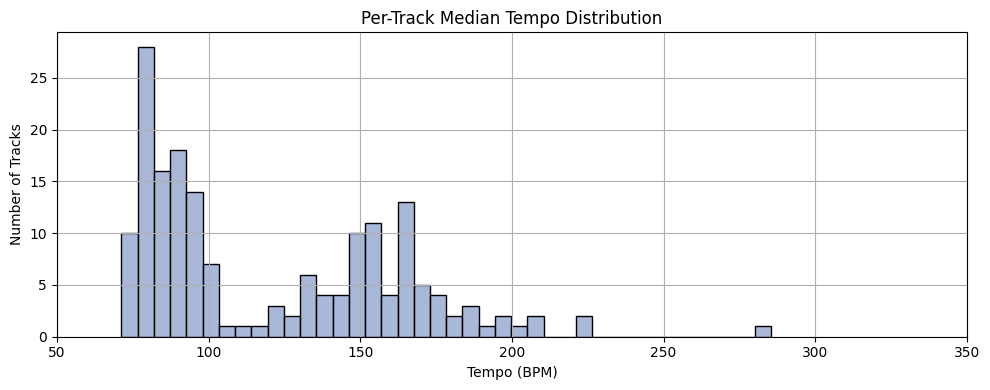

In [15]:
plt.figure(figsize=(10, 4))
sns.histplot(track_medians, bins=40, color=sns.color_palette("Set2")[2], edgecolor='black', kde=False)
plt.title("Per-Track Median Tempo Distribution")
plt.xlim(50, 350)  # <-- Limit x-axis to 0–400
plt.xlabel("Tempo (BPM)")
plt.ylabel("Number of Tracks")
plt.grid(True)
plt.tight_layout()
plt.show()

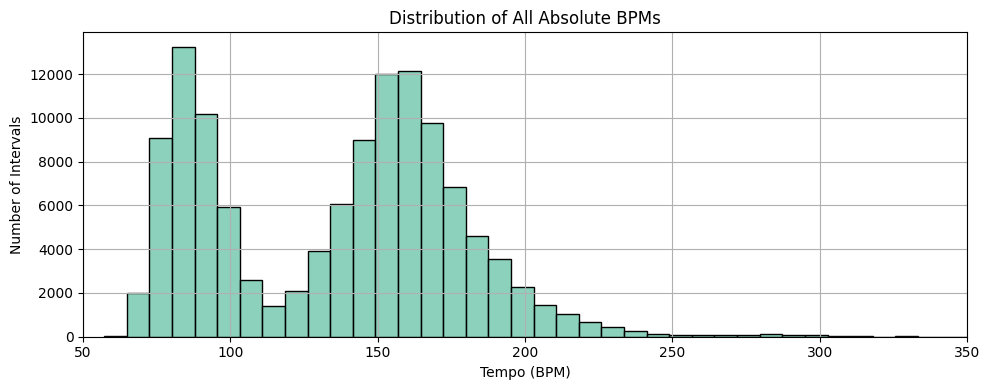

In [16]:
plt.figure(figsize=(10, 4))
sns.histplot(all_tempos, bins=40, color=sns.color_palette("Set2")[0], edgecolor='black', kde=False)
plt.title("Distribution of All Absolute BPMs")
plt.xlabel("Tempo (BPM)")
plt.ylabel("Number of Intervals")
plt.xlim(50, 350)  # <-- Limit x-axis to 0–400
plt.grid(True)
plt.tight_layout()
plt.show()

## Taala-wise Track Tempo Spread

In [17]:
# Create DataFrame
tempo_df = pd.DataFrame(track_tempo_list)

In [18]:
taala_order = ['adi', 'rupakam', 'mishraChapu', 'khandaChapu']
tempo_df['taala'] = pd.Categorical(tempo_df['taala'], categories=taala_order, ordered=True)

#Group by taala and compute summary stats on median BPMs
taala_median_stats = tempo_df.groupby('taala')['median_bpm'].agg(
    min_median='min',              # Minimum of median BPMs across tracks
    max_median='max',              # Maximum of median BPMs
    mean_median='mean',            # Mean of median BPMs
    median_of_medians='median',    # Median of median BPMs
    std_median='std',              # (Optional) Standard deviation
    track_count='count'            # (Optional) Number of tracks
).reset_index()


/var/folders/fv/sqy09dps0vz7wg8jbkcgwk3h0000gn/T/ipykernel_5354/3032227955.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  taala_median_stats = tempo_df.groupby('taala')['median_bpm'].agg(


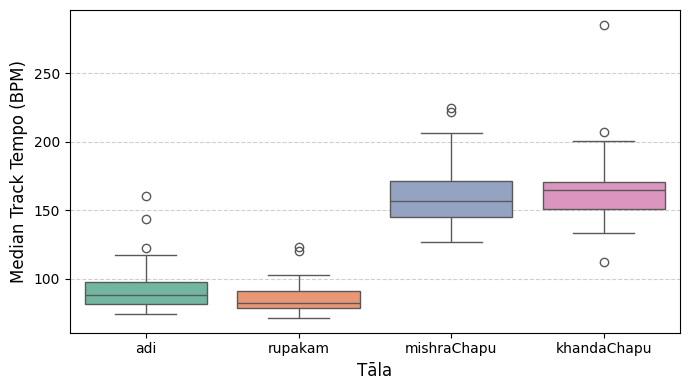

In [ ]:
palette = sns.color_palette("Set2", n_colors=4)
#palette = ["#F72585", "#7209B7", "#3A0CA0", "#4361EE"]
sns.set_palette(palette)


plt.figure(figsize=(7, 4))
ax = sns.boxplot(
    x='taala',
    y='median_bpm',
    data=tempo_df,
    hue='taala',         # Assign x to hue
    palette=palette,
    legend=False
)

# Set alpha for box faces
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, 0.5))  # 0.4 is example alpha value
    
# Labels and title
plt.xlabel('Tāla', fontsize=12)
plt.ylabel('Median Track Tempo (BPM)', fontsize=12)
#plt.title('Tāla-wise Distribution of Median Track Tempo', fontsize=14)

plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
#plt.legend(title='Tāla', loc='upper left')  # Adjust legend position
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

## Taala-wise cycle duration spread

In [20]:
# Create summary list
cycle_summary_list = []

for taala, cycles in taala_cycle_lengths.items():
    if len(cycles) == 0:
        continue
    cycles_array = np.array(cycles)
    cycle_summary_list.append({
        'taala': taala,
        'min_cycle_len(s)': round(np.min(cycles_array),1),
        'max_cycle_len(s)': round(np.max(cycles_array),1),
        'median_cycle_len(s)': round(np.median(cycles_array),1)
    })

#round to 1 decimal


# Convert to DataFrame
df_cycle_summary = pd.DataFrame(cycle_summary_list)

print(df_cycle_summary)

         taala  min_cycle_len(s)  max_cycle_len(s)  median_cycle_len(s)
0          adi               2.9               7.1                  5.4
1      rupakam               1.2               3.1                  2.1
2  mishraChapu               1.6               3.6                  2.6
3  khandaChapu               0.9               2.9                  1.8
